# Assessment 1 Souce Code Notebook 

## import library

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import nltk
from nltk.corpus import reuters
import collections
import math
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

## Data load

In [2]:
path=os.getcwd()
traindata=pd.read_csv(path+'/data.csv',encoding="shift-jis",header=None, names=('difficulty', 'word'),keep_default_na=False)
traindata=traindata.sample(frac=1, random_state=0)
print(len(traindata))
print(traindata.head())

11998
       difficulty         word
6681           11       cobble
11997           7        rouse
11039           7   scandalous
7529            4      farming
11964           7  instinctive


 ## Data processing and Define features
 

I'll define features :

* Word length
* The Proportion of word in reuters / The Proportion rate of word in reuters
* part of speech
* The number of vowels
* The number of consonants
* The Proportion of vowels in a word
* The Proportion of consonants in a word

### Word length

In [3]:
wordLength = []

for i in range(len(traindata)):
    wordLength.append(len(traindata.word.iat[i]))
    
traindata["length"]=wordLength
print(traindata.head())

       difficulty         word  length
6681           11       cobble       6
11997           7        rouse       5
11039           7   scandalous      10
7529            4      farming       7
11964           7  instinctive      11


### The Proportion of word in reuters / The Proportion rate of word in reuters
reference : https://nlpforhackers.io/tf-idf/

In [4]:
tf = []
tfRate=[]
stop_words = stopwords.words('english') + list(punctuation)

def tokenize(text):
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    return [w for w in words if w not in stop_words and not w.isdigit()]

# build the vocabulary in one pass
vocabulary = set()
for file_id in reuters.fileids():
    words = tokenize(reuters.raw(file_id))
    vocabulary.update(words)
 
vocabulary = list(vocabulary)
word_index = {w: idx for idx, w in enumerate(vocabulary)}
 
VOCABULARY_SIZE = len(vocabulary)
DOCUMENTS_COUNT = len(reuters.fileids())
 
wordCount = collections.defaultdict(lambda: 0)
for file_id in reuters.fileids():
    words = set(tokenize(reuters.raw(file_id)))
    for word in words:
        wordCount[word] += 1

sumWords=0
for word in wordCount:
    sumWords+= wordCount[word]
    
for k in range(len(traindata)):
    tf.append(wordCount[traindata.word.iat[k]])
    tfRate.append(wordCount[traindata.word.iat[k]]/sumWords)
        
traindata["tf rate"] = tfRate
traindata["tf"] = tf

print(traindata.head())
print(sumWords)

       difficulty         word  length   tf rate  tf
6681           11       cobble       6  0.000000   0
11997           7        rouse       5  0.000000   0
11039           7   scandalous      10  0.000000   0
7529            4      farming       7  0.000026  16
11964           7  instinctive      11  0.000000   0
610240


### part of speech

In [5]:
a=nltk.pos_tag(traindata.word)
partOfSpeech=[]

for j in range(len(traindata)):
    partOfSpeech.append(a[j][1])
traindata["partOfSpeech"]=partOfSpeech
# len(partOfSpeech)
print(traindata.head())

       difficulty         word  length   tf rate  tf partOfSpeech
6681           11       cobble       6  0.000000   0           JJ
11997           7        rouse       5  0.000000   0           NN
11039           7   scandalous      10  0.000000   0           JJ
7529            4      farming       7  0.000026  16          VBG
11964           7  instinctive      11  0.000000   0           JJ


### The number of vowels / The number of consonants / 
### The Proportion of vowels in a word / The Proportion of consonants in a word



In [6]:
numberOfVowels = []
numberOfConsonants = []
proportionOfVowels = []
proportionOfConsonants = []

for i in range(len(traindata)):
    numberOfVowels.append(traindata.word.iat[i].count('a')+traindata.word.iat[i].count('i')+traindata.word.iat[i].count('u')+traindata.word.iat[i].count('e')+traindata.word.iat[i].count('o'))
    numberOfConsonants.append(traindata.length.iat[i] - (traindata.word.iat[i].count('a')+traindata.word.iat[i].count('i')+traindata.word.iat[i].count('u')+traindata.word.iat[i].count('e')+traindata.word.iat[i].count('o')))
    proportionOfVowels.append((traindata.word.iat[i].count('a')+traindata.word.iat[i].count('i')+traindata.word.iat[i].count('u')+traindata.word.iat[i].count('e')+traindata.word.iat[i].count('o'))/traindata.length.iat[i])
    proportionOfConsonants.append((traindata.length.iat[i] - (traindata.word.iat[i].count('a')+traindata.word.iat[i].count('i')+traindata.word.iat[i].count('u')+traindata.word.iat[i].count('e')+traindata.word.iat[i].count('o')))/traindata.length.iat[i])

traindata["numberOfVowels"] = numberOfVowels
traindata["numberOfConsonants"] = numberOfConsonants
traindata["proportionOfVowels"] = proportionOfVowels
traindata["proportionOfConsonants"] = proportionOfConsonants
print(traindata.head())

       difficulty         word  length   tf rate  tf partOfSpeech  \
6681           11       cobble       6  0.000000   0           JJ   
11997           7        rouse       5  0.000000   0           NN   
11039           7   scandalous      10  0.000000   0           JJ   
7529            4      farming       7  0.000026  16          VBG   
11964           7  instinctive      11  0.000000   0           JJ   

       numberOfVowels  numberOfConsonants  proportionOfVowels  \
6681                2                   4            0.333333   
11997               3                   2            0.600000   
11039               4                   6            0.400000   
7529                2                   5            0.285714   
11964               4                   7            0.363636   

       proportionOfConsonants  
6681                 0.666667  
11997                0.400000  
11039                0.600000  
7529                 0.714286  
11964                0.636364  


### Data Processing

In [7]:
# Convert OneHot Vector 
leSpeech = LabelEncoder()
oeSpeech = OneHotEncoder()
enSpeech = leSpeech.fit_transform(traindata.partOfSpeech)
print(oeSpeech.fit_transform(enSpeech.reshape(-1, 1)).toarray()[0])


tmp = np.array(traindata.values.flatten())
tmp_2 = np.reshape(tmp,(len(traindata),10))
tmp_2 = np.delete(tmp_2, 1, axis=1)
datasetList = np.delete(tmp_2, 4, axis=1)

featuresList = np.delete(datasetList, 0, axis=1)
featuresList = np.c_[featuresList,oeSpeech.fit_transform(enSpeech.reshape(-1, 1)).toarray()]
print(featuresList[0])

labelList = np.delete(datasetList, [1,2,3,4,5,6,7], axis=1)
print(np.reshape(labelList,(len(traindata))))
labelList = np.reshape(labelList,(len(traindata)))

print(traindata.head())

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[6 0.0 0 2 4 0.3333333333333333 0.6666666666666666 0.0 0.0 0.0 0.0 0.0 1.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
[11 7 7 ..., 10 2 8]
       difficulty         word  length   tf rate  tf partOfSpeech  \
6681           11       cobble       6  0.000000   0           JJ   
11997           7        rouse       5  0.000000   0           NN   
11039           7   scandalous      10  0.000000   0           JJ   
7529            4      farming       7  0.000026  16          VBG   
11964           7  instinctive      11  0.000000   0           JJ   

       numberOfVowels  numberOfConsonants  proportionOfVowels  \
6681                2                   4            0.333333   
11997               3                   2            0.600000   
11039               4                   6            0.400000   

In [16]:
len(featuresList[0])

38

## PCA

0.999873371659


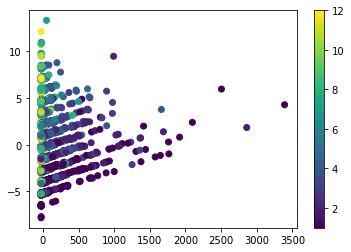

In [8]:
pca1 = PCA(n_components=2)
pca1.fit(featuresList)

featuresList_proj=pca1.fit_transform(featuresList)

print (np.sum(pca1.explained_variance_ratio_))

#plot the PC as a scatter plot
plt.scatter(featuresList_proj[:,0], featuresList_proj[:,1], c=labelList)
plt.colorbar()

plt.show()

In [15]:
print(pca1.explained_variance_ratio_)
print(pca1.components_)

[  9.99166383e-01   7.06988978e-04]
[[ -1.98516768e-03   1.63869458e-06   9.99996982e-01  -7.61585050e-04
   -1.22358263e-03   6.42769807e-06  -6.42769807e-06  -3.22943532e-07
    7.27009925e-05   1.16495974e-06  -3.08781358e-06   2.15872952e-05
   -8.39584626e-05   8.44678907e-07   1.11598179e-06   3.30219816e-05
   -4.53063276e-05  -8.72730930e-06  -1.69040270e-07   1.34831643e-06
   -2.26436518e-06  -1.35181697e-06   1.57955478e-05   1.69311130e-06
    3.11047763e-06  -8.17447787e-07  -1.68929782e-07  -1.62045094e-07
    1.46485521e-05  -7.91367982e-07  -9.38767342e-06   1.09663826e-05
   -1.46346215e-05  -3.71081543e-06  -6.72913532e-07  -1.12480221e-06
    3.81782170e-07  -1.72136388e-06]
 [  8.13021272e-01   4.01683193e-09   2.45123161e-03   3.42731761e-01
    4.70289511e-01   3.75160868e-03  -3.75160868e-03  -2.75853556e-04
   -1.52189453e-04  -6.44075628e-04  -4.38171102e-04  -2.37902761e-03
    1.43115754e-02  -2.59838065e-04  -5.26940559e-04  -1.78254371e-04
   -8.25274455e-0

## SVM

### Raw input

In [9]:
clf=SVC(kernel='linear')
labelListSVM = labelList.tolist()
print(cross_val_score(clf, featuresList, labelListSVM, cv=3))

[ 0.167998    0.16991992  0.17617618]


In [10]:
clf_rbf=SVC(kernel='rbf', gamma=0.001)
    
print(cross_val_score(clf_rbf, featuresList, labelListSVM, cv=3))

[ 0.167998    0.15740741  0.16291291]


### PCA Input

In [11]:
featuresListd = pca1.transform(featuresList)

In [12]:
clf2=SVC(kernel='linear')
labelListSVM = labelList.tolist()
print(cross_val_score(clf2, featuresListd, labelListSVM, cv=3))

[ 0.16125811  0.16391391  0.16791792]


In [13]:
clf_rbf2=SVC(kernel='rbf', gamma=0.001)
    
print(cross_val_score(clf_rbf2, featuresListd, labelListSVM, cv=3))

[ 0.16475287  0.15990991  0.16216216]


### test onle PC2

In [21]:
print(np.delete(featuresListd,0,axis=1))
print(featuresListd)
featuresListd2=np.delete(featuresListd,0,axis=1)

[[-1.51454789]
 [-2.94597988]
 [ 3.36407996]
 ..., 
 [-2.79490723]
 [-1.53711221]
 [-0.37819335]]
[[-24.54941241  -1.51454789]
 [-24.54569959  -2.94597988]
 [-24.56132256   3.36407996]
 ..., 
 [-23.54620583  -2.79490723]
 [-24.54937376  -1.53711221]
 [-23.55212231  -0.37819335]]


In [22]:
clf3=SVC(kernel='linear')
labelListSVM = labelList.tolist()
print(cross_val_score(clf3, featuresListd2, labelListSVM, cv=3))

[ 0.12880679  0.13488488  0.14089089]


In [23]:
clf_rbf3=SVC(kernel='rbf', gamma=0.001)
print(cross_val_score(clf_rbf3, featuresListd2, labelListSVM, cv=3))

[ 0.12755866  0.13413413  0.14089089]


### PC2 and PC3

0.999948996861


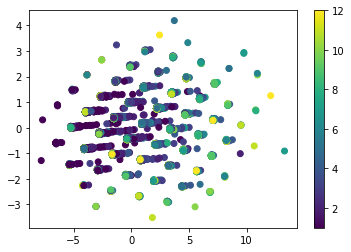

In [24]:
pca2 = PCA(n_components=3)
pca2.fit(featuresList)

featuresList_proj2=pca2.fit_transform(featuresList)

print (np.sum(pca2.explained_variance_ratio_))

#plot the PC as a scatter plot
plt.scatter(featuresList_proj2[:,1], featuresList_proj2[:,2], c=labelList)
plt.colorbar()

plt.show()

In [27]:
featuresListd3 = pca2.transform(featuresList)
featuresListd3 = np.delete(featuresListd3,0,axis=1)
featuresListd3

array([[-1.51454789,  0.35637969],
       [-2.94597988, -1.64596971],
       [ 3.36407996, -0.08870079],
       ..., 
       [-2.79490723, -0.24499631],
       [-1.53711221,  0.38766668],
       [-0.37819335, -0.43529894]])

In [28]:
clf4=SVC(kernel='linear')
labelListSVM = labelList.tolist()
print(cross_val_score(clf4, featuresListd3, labelListSVM, cv=3))

[ 0.12855716  0.14264264  0.12812813]


In [29]:
clf_rbf4=SVC(kernel='rbf', gamma=0.001)
    
print(cross_val_score(clf_rbf4, featuresListd3, labelListSVM, cv=3))

[ 0.12680979  0.13788789  0.13638639]


## DNN

### all bach

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
import keras
import numpy as np
leLabel = LabelEncoder()
oeLavel = OneHotEncoder()
enLabel = leLabel.fit_transform(labelList)
print(oeLavel.fit_transform(enLabel.reshape(-1, 1)).toarray()[0])

x_train = featuresList
y_train = keras.utils.to_categorical(enLabel, num_classes=12)
x_test = featuresList
y_test = keras.utils.to_categorical(enLabel, num_classes=12)

model = Sequential()
model.add(Dense(100, activation='relu', input_dim=38))
model.add(Dense(100, activation='relu'))
model.add(Dense(12, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(x_train, y_train,epochs=20,batch_size=100)
score = model.evaluate(x_test, y_test, batch_size=100)
print("loss",score[0])
print("accuracy",score[1])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
Epoch 1/20
11998/11998 [==============================] - 2s 129us/step - loss: 3.2062 - acc: 0.1185
Epoch 2/20
11998/11998 [==============================] - 1s 68us/step - loss: 2.3689 - acc: 0.1338
Epoch 3/20
11998/11998 [==============================] - 1s 70us/step - loss: 2.3339 - acc: 0.1525
Epoch 4/20
11998/11998 [==============================] - 1s 79us/step - loss: 2.3240 - acc: 0.1543
Epoch 5/20
11998/11998 [==============================] - 1s 83us/step - loss: 2.3187 - acc: 0.1623
Epoch 6/20
11998/11998 [==============================] - 1s 71us/step - loss: 2.3107 - acc: 0.1655
Epoch 7/20
11998/11998 [==============================] - 1s 57us/step - loss: 2.3052 - acc: 0.1695
Epoch 8/20
11998/11998 [==============================] - 1s 83us/step - loss: 2.3048 - acc: 0.1697
Epoch 9/20
11998/11998 [==============================] - 1s 60us/step - loss: 2.3264 - acc: 0.1672
Epoch 10/20
11998/11998 [========================

### Cross-validation

In [47]:
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
import keras
import numpy as np
leLabel = LabelEncoder()
oeLavel = OneHotEncoder()
enLabel = leLabel.fit_transform(labelList)
print(oeLavel.fit_transform(enLabel.reshape(-1, 1)).toarray()[0])

labelCate=keras.utils.to_categorical(enLabel, num_classes=12)

lossList = []
accuracyList = []
# cross validation
kf = sklearn.model_selection.KFold(3, shuffle=True)
for train_indices, test_indices in kf.split(featuresList, labelCate):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=38))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(12, activation='softmax'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    # 学習
    X_train = featuresList[train_indices]
    y_train = labelCate[train_indices]
    X_test = featuresList[test_indices]
    y_test = labelCate[test_indices]
    hist = model.fit(X_train, y_train,epochs=20,batch_size=100)
    score = model.evaluate(X_test, y_test, batch_size=100)
    lossList.append(score[0])
    accuracyList.append(score[1])
    print("loss",score[0])
    print("accuracy",score[1])

print(lossList)
print(accuracyList)
print("Loss mean",sum(lossList)/len(lossList))
print("accuracy mean",sum(accuracyList)/len(accuracyList))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
Epoch 1/20
7998/7998 [==============================] - 2s 214us/step - loss: 2.8332 - acc: 0.1199
Epoch 2/20
7998/7998 [==============================] - 1s 83us/step - loss: 2.7336 - acc: 0.1359
Epoch 3/20
7998/7998 [==============================] - 1s 89us/step - loss: 2.3655 - acc: 0.1429
Epoch 4/20
7998/7998 [==============================] - 1s 66us/step - loss: 2.3780 - acc: 0.1438
Epoch 5/20
7998/7998 [==============================] - 1s 76us/step - loss: 2.3466 - acc: 0.1480
Epoch 6/20
7998/7998 [==============================] - 1s 71us/step - loss: 2.3265 - acc: 0.1489
Epoch 7/20
7998/7998 [==============================] - 1s 72us/step - loss: 2.3177 - acc: 0.1555
Epoch 8/20
7998/7998 [==============================] - 0s 49us/step - loss: 2.3159 - acc: 0.1603
Epoch 9/20
7998/7998 [==============================] - 1s 73us/step - loss: 2.3162 - acc: 0.1579
Epoch 10/20
7998/7998 [==============================] - 1s 74us/st

In [48]:
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
import keras
import numpy as np
leLabel = LabelEncoder()
oeLavel = OneHotEncoder()
enLabel = leLabel.fit_transform(labelList)
print(oeLavel.fit_transform(enLabel.reshape(-1, 1)).toarray()[0])

labelCate=keras.utils.to_categorical(enLabel, num_classes=12)

lossList = []
accuracyList = []
# cross validation
kf = sklearn.model_selection.KFold(3, shuffle=True)
for train_indices, test_indices in kf.split(featuresListd, labelCate):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=38))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(12, activation='softmax'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    # 学習
    X_train = featuresList[train_indices]
    y_train = labelCate[train_indices]
    X_test = featuresList[test_indices]
    y_test = labelCate[test_indices]
    hist = model.fit(X_train, y_train,epochs=20,batch_size=100)
    score = model.evaluate(X_test, y_test, batch_size=100)
    lossList.append(score[0])
    accuracyList.append(score[1])
    print("loss",score[0])
    print("accuracy",score[1])

print(lossList)
print(accuracyList)
print("Loss mean",sum(lossList)/len(lossList))
print("accuracy mean",sum(accuracyList)/len(accuracyList))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
Epoch 1/20
7998/7998 [==============================] - 2s 218us/step - loss: 3.0879 - acc: 0.1235
Epoch 2/20
7998/7998 [==============================] - 1s 96us/step - loss: 2.4555 - acc: 0.1259
Epoch 3/20
7998/7998 [==============================] - 1s 69us/step - loss: 2.3892 - acc: 0.1375
Epoch 4/20
7998/7998 [==============================] - 1s 80us/step - loss: 2.3490 - acc: 0.1434
Epoch 5/20
7998/7998 [==============================] - 1s 82us/step - loss: 2.3323 - acc: 0.1540
Epoch 6/20
7998/7998 [==============================] - 1s 73us/step - loss: 2.3354 - acc: 0.1548
Epoch 7/20
7998/7998 [==============================] - 1s 70us/step - loss: 2.3219 - acc: 0.1592
Epoch 8/20
7998/7998 [==============================] - 1s 85us/step - loss: 2.3176 - acc: 0.1618
Epoch 9/20
7998/7998 [==============================] - 1s 72us/step - loss: 2.3119 - acc: 0.1648
Epoch 10/20
7998/7998 [==============================] - 1s 87us/st